# Preparação do ambiente

## Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
import warnings

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from os import path as osp
from tqdm.auto import tqdm
from unicodedata import normalize
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Constantes e funções auxiliares

In [2]:
FILE_ITEMS = '../datasets/label_issues/20240423/results/items.parquet'
FILE_SAMPLES_RESULTS = '../datasets/label_issues/20240423/results/samples_results.parquet'

In [17]:
def clean_text(doc, return_tokens=False, nltk_tokenizer=True):

    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(string.punctuation))
    
    # stopwords específicas do domínio
    # stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver'])
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", relevante para o domínio
    # primeira rodada de classificação demonstrou que não foi uma boa escolha
    # testes nessa rodada confirmaram que não faz difença
    # stop_words.remove('sem')
    
    doc = doc.lower()
    doc = normalize('NFKD', doc).encode('ASCII', 'ignore').decode('ASCII')

    # word regularization
    # wi-fi
    pattern = 'wi.fi'
    doc = re.sub(pattern, 'wifi', doc)
    
    # 2.4g and variations
    pattern = '2[.,]4(?:[0-9]+)?g(?:hz)?' 
    doc = re.sub(pattern, '2_4ghz', doc)
    # Scikit vectorizers remove punctuations between characters, so
    # to prevent 2.4g becomes 4g, remove punctuation early
    
    # 5.8g and variations
    pattern = '5[.,]8(?:[0-9]+)?g(?:hz)?' 
    doc = re.sub(pattern, '5_8ghz', doc)
    # Scikit vectorizers remove punctuations between characters, so
    # to prevent 5.8g becomes 8g, remove punctuation early

    if nltk_tokenizer:
        # nltk tokenizer
        tokens = [token for token in word_tokenize(doc, language='portuguese') if token not in stop_words]
    else:
        # CountVectorizer token pattern
        pattern = r'\b\w\w+\b'
        tokens = [token for token in re.findall(pattern,doc) if token not in stop_words]

    if return_tokens:
        return tokens
    else:
        return ' '.join(tokens)

In [4]:
def extract_features(docs,min_df=1,ngram_range=(1,1),binary=False,tokenizer=None):
    vectorizer = CountVectorizer(min_df=min_df,ngram_range=ngram_range,binary=binary)
    docs_matrix = vectorizer.fit_transform(docs)
    features_names = vectorizer.get_feature_names_out()
    features_counts = docs_matrix.toarray().sum(axis=0)
    # reorder features by count (max -> min)
    i = features_counts.argsort()[::-1]
    features = {feature:count for feature,count in zip(features_names[i],features_counts[i])}
    return features

# Carga e prepação dos dados

In [5]:
df_items = pd.read_parquet(FILE_ITEMS)
df_items['doc'] = df_items['nome'].map(clean_text)
df_items['tokens'] = df_items['nome'].apply(lambda doc: clean_text(doc, return_tokens=True))

columns_to_keep = ['id', 'nome', 'doc', 'tokens', 
                   'titulo_bem_elaborado', 'titulo_identifica_produto',
                   'passivel_homologacao', 'transmissor_rf', 'tipo_produto']

df_items = df_items[columns_to_keep]

docs = df_items[df_items['passivel_homologacao']<=1]['nome']
labels = df_items[df_items['passivel_homologacao']<=1]['passivel_homologacao']

df_items

,id,nome,doc,tokens,titulo_bem_elaborado,titulo_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto
0,126504,Controle Remoto Tv Samsung Smart,controle remoto tv samsung smart,"[controle, remoto, tv, samsung, smart]",1,1,1,1,Transceptor de radiofrequência (VHF/UHF)
1,126505,Smartphone Redmi 9t Xiaomi Com Película E Capa...,smartphone redmi 9t xiaomi pelicula capa seminovo,"[smartphone, redmi, 9t, xiaomi, pelicula, capa...",1,1,1,1,Smartphones
2,126506,Drone DJI Mini 3 Pro DJI RC-N1 (Sem tela) Fly ...,drone dji mini 3 pro dji rc-n1 sem tela fly ki...,"[drone, dji, mini, 3, pro, dji, rc-n1, sem, te...",1,1,1,1,Drone
3,126507,Smartphone Samsumg J5 Prime,smartphone samsumg j5 prime,"[smartphone, samsumg, j5, prime]",1,1,1,1,Smartphones
4,126508,"Tablet PC, 12 GB RAM 256 GB ROM US Plug 100-24...",tablet pc 12 gb ram 256 gb rom us plug 100-240...,"[tablet, pc, 12, gb, ram, 256, gb, rom, us, pl...",1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
...,...,...,...,...,...,...,...,...,...
4347,125715,CAIXA ACUSTICA PCX6500,caixa acustica pcx6500,"[caixa, acustica, pcx6500]",0,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
4348,125716,Conector de cauda de celular 10 pcs carregando...,conector cauda celular 10 pcs carregando conec...,"[conector, cauda, celular, 10, pcs, carregando...",1,1,0,0,Outro tipo/categoria (não listada acima)
4349,125717,Avantree Medley Clear - Fones de ouvido sem fi...,avantree medley clear fones ouvido sem fio ouv...,"[avantree, medley, clear, fones, ouvido, sem, ...",1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
4350,125718,"Hilitand Adaptador sem fio, placa de rede sem ...",hilitand adaptador sem fio placa rede sem fio ...,"[hilitand, adaptador, sem, fio, placa, rede, s...",1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)


# Análise

## Frequência de termos e de documentos

In [6]:
n_top = 20

raw_features = extract_features(df_items['nome'],min_df=1,ngram_range=(1,2))
clean_features = extract_features(df_items['doc'],min_df=1,ngram_range=(1,2))

print(f'Total features from raw text: {len(raw_features)}')
print(f'Total features from clean text: {len(clean_features)}')

print(f'Total features that occurs once from clean text: {len([f[0] for f in clean_features.items() if f[1]==1])}')

print(f'Top {n_top} Most frequent features from raw text:')
for feature in list(raw_features.items())[:n_top]:
    print('  ',feature)

print(f'Top {n_top} Most frequent features from clean text:')
for feature in list(clean_features.items())[:n_top]:
    print('  ',feature)


Total features from raw text: 44144
Total features from clean text: 44036
Total features that occurs once from clean text: 33964
Top 20 Most frequent features from raw text:
   ('de', 6580)
   ('para', 2902)
   ('com', 1214)
   ('sem', 854)
   ('fio', 801)
   ('sem fio', 755)
   ('usb', 687)
   ('bluetooth', 626)
   ('câmera', 616)
   ('drone', 555)
   ('capa', 522)
   ('carregador', 520)
   ('cabo', 507)
   ('bateria', 506)
   ('wifi', 481)
   ('transmissor', 473)
   ('celular', 448)
   ('adaptador', 438)
   ('carregamento', 386)
   ('receptor', 376)
Top 20 Most frequent features from clean text:
   ('sem', 854)
   ('fio', 801)
   ('sem fio', 755)
   ('usb', 687)
   ('camera', 673)
   ('wifi', 657)
   ('bluetooth', 626)
   ('drone', 555)
   ('capa', 522)
   ('carregador', 520)
   ('bateria', 512)
   ('cabo', 507)
   ('transmissor', 473)
   ('celular', 448)
   ('adaptador', 438)
   ('carregamento', 386)
   ('receptor', 376)
   ('telefone', 353)
   ('portatil', 352)
   ('preto', 352)


## Classificadores

### Pesquisa de parâmetros

In [8]:
%%time
# vetorizar as palavras por contagem
vectorizer = CountVectorizer()

# transformar vetores aplicando TF-IDF
transformer = TfidfTransformer()

# classificardor SGD
clf = SGDClassifier(alpha=1e-5, loss='log_loss', penalty='l2')

# juntar tudo em pipeline
pipe = Pipeline(steps = [('vectorizer',vectorizer),('transformer',transformer),('clf',clf)])

# tokenizers
tokenizer = lambda doc: clean_text(doc, return_tokens=True)
nltk_tokenizer = lambda doc: clean_text(doc, return_tokens=True, nltk_tokenizer=True)

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'vectorizer__min_df': [1, 2, 3],
    'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
    'vectorizer__tokenizer': [None, tokenizer, nltk_tokenizer]
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    search = GridSearchCV(pipe, param_grid, n_jobs=1, scoring='roc_auc')
    search.fit(docs, labels)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

Best parameter (CV score=0.944):
{'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__tokenizer': None}
CPU times: total: 4min 46s
Wall time: 4min 25s


In [9]:
df_cv_results = pd.DataFrame(search.cv_results_['params'])
df_cv_results['mean_test_score'] = search.cv_results_['mean_test_score']
df_cv_results.sort_values(by='mean_test_score',ascending=False).head(5)

,vectorizer__min_df,vectorizer__ngram_range,vectorizer__tokenizer,mean_test_score
3,1,"(1, 2)",None,0.944233
5,1,"(1, 2)",<function <lambda> at 0x000001533FE91D80>,0.943426
4,1,"(1, 2)",<function <lambda> at 0x000001533FE91CF0>,0.943198
6,1,"(1, 3)",None,0.943148
7,1,"(1, 3)",<function <lambda> at 0x000001533FE91CF0>,0.942614


### Classificador com melhores parâmetros

In [10]:
target_names = ['Não passíveis de homologação','Passíveis de homologação']
target_names_confusion = ['Não passíveis\nde homologação','Passíveis\nde homologação']

stop_words = stopwords.words('portuguese')
stop_words.extend(stopwords.words('english'))

Accuracy of SGD classifier on training set: 1.000
Accuracy of SGD classifier on test set: 0.881
AUC of SGD classifier on training set: 1.000
AUC of SGD classifier on test set: 0.940

                              precision    recall  f1-score   support

Não passíveis de homologação       0.89      0.81      0.84       401
    Passíveis de homologação       0.88      0.93      0.90       596

                    accuracy                           0.88       997
                   macro avg       0.88      0.87      0.87       997
                weighted avg       0.88      0.88      0.88       997



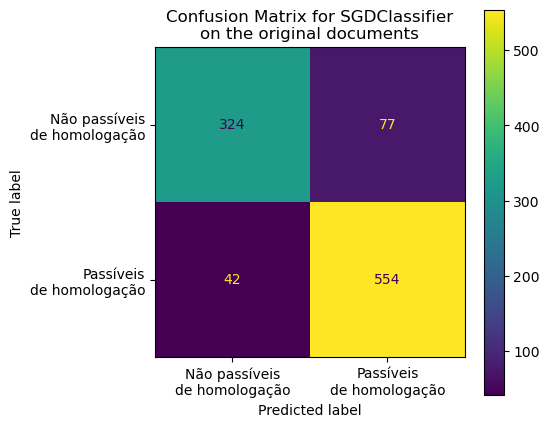

In [11]:
# vetorizar as palavras por contagem
vectorizer = CountVectorizer(ngram_range=(1,2),stop_words=stop_words)

# transformar vetores aplicando TF-IDF
transformer = TfidfTransformer()

# classificardor SGD
clf = SGDClassifier(alpha=1e-5, loss='log_loss', penalty='l2')

# juntar tudo em pipeline
pipe = Pipeline(steps = [('vectorizer',vectorizer),('transformer',transformer),('clf',clf)])

docs = df_items[df_items['passivel_homologacao']<=1]['nome']
labels = df_items[df_items['passivel_homologacao']<=1]['passivel_homologacao']

X_train, X_test, y_train, y_test = train_test_split(docs, labels, test_size=0.25, random_state=123)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe.fit(X_train,y_train)

predicted = pipe.predict(X_test)

print('Accuracy of SGD classifier on training set: {:.3f}'
     .format(pipe.score(X_train, y_train)))
print('Accuracy of SGD classifier on test set: {:.3f}'
     .format(pipe.score(X_test, y_test)))
print('AUC of SGD classifier on training set: {:.3f}'
     .format(roc_auc_score(y_train,pipe.predict_proba(X_train)[:,1])))
print('AUC of SGD classifier on test set: {:.3f}'
     .format(roc_auc_score(y_test,pipe.predict_proba(X_test)[:,1])))

print()
print(classification_report(y_test, predicted, target_names=target_names))

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_test, predicted, ax=ax)
ax.xaxis.set_ticklabels(target_names_confusion)
ax.yaxis.set_ticklabels(target_names_confusion)
_ = ax.set_title(f"Confusion Matrix for {pipe['clf'].__class__.__name__}\non the original documents")

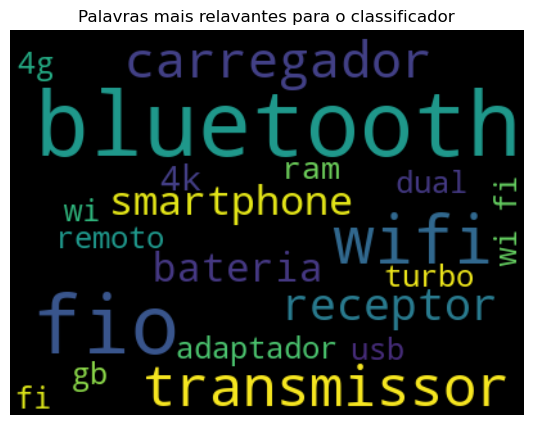

In [12]:
n_top_features = 20
label = target_names[-1]
feature_names = pipe['vectorizer'].get_feature_names_out()
X_train_count_vectors = pipe['vectorizer'].transform(X_train)
X_train_tfidf_vectors = pipe['transformer'].transform(X_train_count_vectors)
clf_coef = pipe['clf'].coef_
average_feature_effects = clf_coef * np.asarray(X_train_tfidf_vectors.mean(axis=0)).ravel()

top_indices = np.argsort(average_feature_effects[0])[-n_top_features:][::-1]
top = pd.DataFrame(feature_names[top_indices], columns=[label])
predictive_words = feature_names[top_indices]

top_featrues_frequency = {word:relevance for word,relevance in zip(predictive_words,average_feature_effects[0, top_indices])}
wc_top_featrues_frequency = WordCloud(height=300,random_state=100).generate_from_frequencies(top_featrues_frequency)
 
fig,ax = plt.subplots(1,1,figsize=(8,5))   
ax.imshow(wc_top_featrues_frequency, interpolation="bilinear")
ax.axis("off")
ax.set_title('Palavras mais relavantes para o classificador')
plt.show()

### Classificador com tokenizador customizado

Accuracy of SGD classifier on training set: 1.000
Accuracy of SGD classifier on test set: 0.884
AUC of SGD classifier on training set: 1.000
AUC of SGD classifier on test set: 0.940

                              precision    recall  f1-score   support

Não passíveis de homologação       0.89      0.81      0.85       401
    Passíveis de homologação       0.88      0.93      0.91       596

                    accuracy                           0.88       997
                   macro avg       0.89      0.87      0.88       997
                weighted avg       0.88      0.88      0.88       997



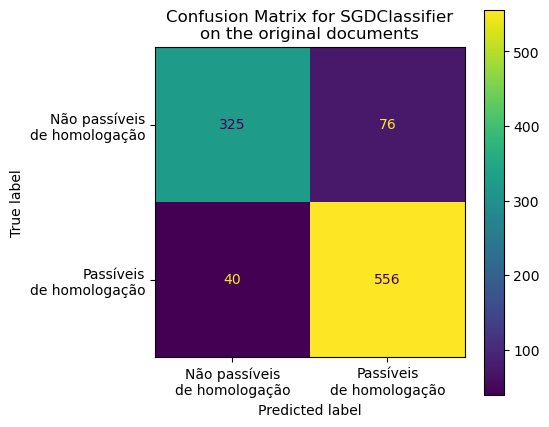

In [18]:
# vetorizar as palavras por contagem
tokenizer = lambda doc: clean_text(doc, return_tokens=True, nltk_tokenizer=False)
vectorizer = CountVectorizer(ngram_range=(1,2),tokenizer=tokenizer)

# transformar vetores aplicando TF-IDF
transformer = TfidfTransformer()

# classificardor SGD
clf = SGDClassifier(alpha=1e-5, loss='log_loss', penalty='l2')

# juntar tudo em pipeline
pipe = Pipeline(steps = [('vectorizer',vectorizer),('transformer',transformer),('clf',clf)])

docs = df_items[df_items['passivel_homologacao']<=1]['nome']
labels = df_items[df_items['passivel_homologacao']<=1]['passivel_homologacao']

X_train, X_test, y_train, y_test = train_test_split(docs, labels, test_size=0.25, random_state=123)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe.fit(X_train,y_train)

predicted = pipe.predict(X_test)

print('Accuracy of SGD classifier on training set: {:.3f}'
     .format(pipe.score(X_train, y_train)))
print('Accuracy of SGD classifier on test set: {:.3f}'
     .format(pipe.score(X_test, y_test)))
print('AUC of SGD classifier on training set: {:.3f}'
     .format(roc_auc_score(y_train,pipe.predict_proba(X_train)[:,1])))
print('AUC of SGD classifier on test set: {:.3f}'
     .format(roc_auc_score(y_test,pipe.predict_proba(X_test)[:,1])))

print()
print(classification_report(y_test, predicted, target_names=target_names))

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_test, predicted, ax=ax)
ax.xaxis.set_ticklabels(target_names_confusion)
ax.yaxis.set_ticklabels(target_names_confusion)
_ = ax.set_title(f"Confusion Matrix for {pipe['clf'].__class__.__name__}\non the original documents")

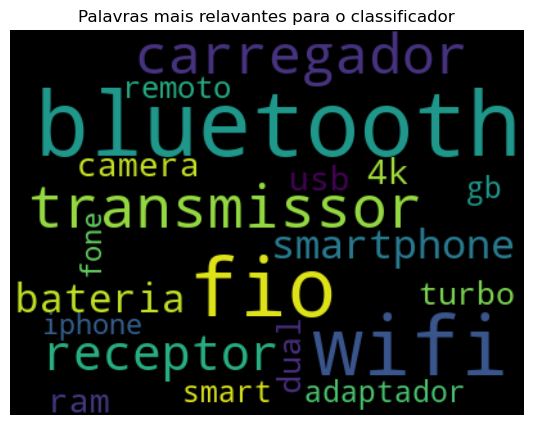

In [19]:
n_top_features = 20
label = target_names[-1]
feature_names = pipe['vectorizer'].get_feature_names_out()
X_train_count_vectors = pipe['vectorizer'].transform(X_train)
X_train_tfidf_vectors = pipe['transformer'].transform(X_train_count_vectors)
clf_coef = pipe['clf'].coef_
average_feature_effects = clf_coef * np.asarray(X_train_tfidf_vectors.mean(axis=0)).ravel()

top_indices = np.argsort(average_feature_effects[0])[-n_top_features:][::-1]
top = pd.DataFrame(feature_names[top_indices], columns=[label])
predictive_words = feature_names[top_indices]

top_featrues_frequency = {word:relevance for word,relevance in zip(predictive_words,average_feature_effects[0, top_indices])}
wc_top_featrues_frequency = WordCloud(height=300,random_state=100).generate_from_frequencies(top_featrues_frequency)
 
fig,ax = plt.subplots(1,1,figsize=(8,5))   
ax.imshow(wc_top_featrues_frequency, interpolation="bilinear")
ax.axis("off")
ax.set_title('Palavras mais relavantes para o classificador')
plt.show()

In [20]:
predictive_words

array(['bluetooth', 'wifi', 'fio', 'transmissor', 'carregador',
       'receptor', 'smartphone', 'bateria', '4k', 'usb', 'ram', 'camera',
       'turbo', 'dual', 'remoto', 'adaptador', 'gb', 'smart', 'fone',
       'iphone'], dtype=object)

**Resultados**

A tabela abaixo apresenta os resultados obtidos com variações do tokenizador customizado

| | Tokenizador Completo | Removida stopword "sem" | Sem regularizar wi-fi | Sem regularizar 2.4/5.8 | Regularizar wi-fi, sem regularizar 2.4/5.8 | Regularizar wi-fi e 2.4/5.8 |
| -- | -- | -- | -- | -- | -- | -- |
| | 0.939 | 0.939 | 0.939 | 0.938 | 0.938 | 0.940 |
| 1 | bluetooth | bluetooth | bluetooth | bluetooth | bluetooth | bluetooth |
| 2 | wifi | wifi | fio | fio | wifi | wifi |
| 3 | sem | fio | wifi | wifi | fio | fio  |
| 4 | fio | transmissor | transmissor | transmissor | transmissor | transmissor |
| 5 | sem fio | carregador | carregador | carregador | carregador | carregador |
| 6 | carregador | receptor | receptor | receptor | receptor | receptor |
| 7 | transmissor | smartphone | smartphone | smartphone | smartphone | smartphone |
| 8 | receptor | bateria | wi-fi | wi-fi | bateria | bateria |
| 9 | smartphone | 4k | bateria | bateria | 4k | 4k |
| 10 | bateria | ram | 4k | 4k | ram | usb |

A partir desse ponto, prosseguir os experimentos com tokenizador customizado com regularização de wi-fi e 2.4/5.8 e tokenizador utilizando o padrão do CountVectorizer do Scikit-learn.

Experimentar se a retirada de *stop words* específicas do domínio, como por exemplo as palavras ram, 4k, usb, etc. que não discriminam produtos passíveis de homologação, resultará em melhora de desempenho do classificador.